# X5

In [1]:
import random

import numpy as np
import pandas as pd

import torch

torch.cuda.empty_cache()

def seed_all(seed: int) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

In [2]:
SEED = 42
seed_all(SEED)

In [3]:
from pathlib import Path

DATA_PATH = Path('../../../data/')
DATA_PATH.mkdir(parents=True, exist_ok=True)

DATA_PATH_DOWNLOAD = DATA_PATH / Path('download/')
DATA_PATH_DOWNLOAD.mkdir(parents=True, exist_ok=True)

DATA_PATH_DATASET = DATA_PATH / Path('datasets/')
DATA_PATH_DATASET.mkdir(parents=True, exist_ok=True)

DATA_SYNTHETICS = DATA_PATH / Path('synthetics/')
DATA_PATH_DATASET.mkdir(parents=True, exist_ok=True)

DATA_CACHE = DATA_PATH / Path('cache_dir/')
DATA_CACHE.mkdir(parents=True, exist_ok=True)

DATA_PATH_SAVE_MODELS = DATA_PATH / Path('models/')
DATA_PATH_SAVE_MODELS.mkdir(parents=True, exist_ok=True)

DATA_IMGS = DATA_PATH /  Path('imgs/')
DATA_IMGS.mkdir(parents=True, exist_ok=True)

import pandas as pd

pd.set_option('display.max_colwidth', 500) 

In [4]:
import sys
import os

project_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(project_path)

In [5]:
BASE_MODEL_NAME = 'cointegrated/rubert-tiny2'
# BASE_MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MODEL_NAME_SAVE = "ner_x5"
MODEL_CHECKPOINT_PATH = "ner_x5_checkpoint"

In [6]:
from datetime import datetime

current_date = datetime.now().strftime("%d-%m-%Y")
DATA_LOG = DATA_PATH / Path(f'../log/{MODEL_NAME_SAVE}_{current_date}')
DATA_LOG.mkdir(parents=True, exist_ok=True)

In [7]:
MAX_LENGTH = 10
BATCH_SIZE = 64

# Данные

In [8]:
df_x5 = pd.read_csv(DATA_PATH_DATASET / "train.csv", sep=";")

df_x5.sample(5)

,sample,annotation
11743,лсвежитель,"[(0, 10, 'B-TYPE')]"
4384,варенец останкинск,"[(0, 7, 'B-TYPE'), (8, 18, 'B-BRAND')]"
8069,кабачковая икра,"[(0, 10, 'B-TYPE'), (11, 15, 'I-TYPE')]"
24552,фитики,"[(0, 6, 'B-TYPE')]"
18475,ресень,"[(0, 6, 'B-TYPE')]"


In [9]:
def normalize_annotations(ann_list):
    if isinstance(ann_list, str):
        ann_list = eval(ann_list)
    new_list = []
    for start, end, label in ann_list:
        if label == "0":
            label = "O"
        new_list.append((start, end, label))
    return new_list

df_x5["annotation"] = df_x5["annotation"].apply(normalize_annotations)

In [10]:
all_labels = set()

for ann_list in df_x5["annotation"]:
    if isinstance(ann_list, str):
        ann_list = eval(ann_list)
    for _, _, label in ann_list:
        all_labels.add(label)

unique_labels = sorted(all_labels)
unique_labels

['B-BRAND',
 'B-PERCENT',
 'B-TYPE',
 'B-VOLUME',
 'I-BRAND',
 'I-PERCENT',
 'I-TYPE',
 'I-VOLUME',
 'O']

In [11]:
df_x5.sample(5)

,sample,annotation
14257,наплднитель,"[(0, 11, B-TYPE)]"
7201,заливные афанасий,"[(0, 8, B-TYPE), (9, 17, B-BRAND)]"
14964,одивковое,"[(0, 9, B-TYPE)]"
15261,освежите,"[(0, 8, B-TYPE)]"
9874,копченостих,"[(0, 11, B-TYPE)]"


In [12]:
import pandas as pd
from pathlib import Path
import ast

def load_synthetic_file(file_path: str | Path) -> pd.DataFrame:
    file_path = Path(file_path)
    data = []

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            try:
                text, ann_str = line.split(";", 1)
                text = text.strip()
                annotation = ast.literal_eval(ann_str.strip())
                data.append({"sample": text, "annotation": annotation})
            except Exception as e:
                print(f"Ошибка при обработке строки в {file_path}: {line}\n{e}")

    return pd.DataFrame(data)


In [13]:
def load_synthetic_dataset(data_dir: str | Path) -> pd.DataFrame:
    data_dir = Path(data_dir)
    all_dfs = []

    for file_path in data_dir.glob("*.txt"):
        df_file = load_synthetic_file(file_path)
        all_dfs.append(df_file)

    if all_dfs:
        return pd.concat(all_dfs).reset_index(drop=True)
    else:
        return pd.DataFrame(columns=["sample", "annotation"])


In [14]:
df_synthetic = load_synthetic_dataset(DATA_SYNTHETICS)

Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: молоко простоквашино 3.2% 1 л и хлеб дарницкий 400 г;
invalid syntax (<unknown>, line 0)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: [(0, 6, "B-TYPE"), (7, 19, "B-BRAND"), (20, 24, "B-PERCENT"), (25, 28, "B-VOLUME"), (31, 35, "B-TYPE"), (36, 45, "B-BRAND"), (46, 51, "B-VOLUME")]
not enough values to unpack (expected 2, got 1)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: кефир валио 1% 930 г и сыр президент 45% 200 г;
invalid syntax (<unknown>, line 0)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: [(0, 5, "B-TYPE"), (6, 11, "B-BRAND"), (12, 14, "B-PERCENT"), (15, 20, "B-VOLUME"), (23, 26, "B-TYPE"), (27, 36, "B-BRAND"), (37, 41, "B-PERCENT"), (42, 47, "B-VOLUME")]
not enough values to unpack (expected 2, got 1)
Ошибка при обработке строки в ..\..\..\data\synthetics\common.txt: шоколад милка 90 г и печенье юбилейное 300 г;
invalid syntax (<unknown>, line 0)

In [15]:
df_x5["df_label"] = "x5"
df_synthetic["df_label"] = "synthetic"

In [16]:
df_train = pd.concat([df_synthetic, df_x5], ignore_index=True)
df_train = df_train.drop_duplicates(subset=["sample"]).reset_index(drop=True)

In [17]:
df_synthetic.sample(5)

,sample,annotation,df_label
48,Velkom Останкино Рублёвский,"[(0, 6, B-BRAND), (7, 16, B-BRAND), (17, 27, B-BRAND)]",synthetic
374,шоколад бабаевский темный 100 г,"[(0, 7, B-TYPE), (8, 18, B-BRAND), (25, 30, B-VOLUME)]",synthetic
168,возьми масло сливочное валио 180 г 82%,"[(7, 12, B-TYPE), (24, 29, B-BRAND), (30, 35, B-VOLUME), (36, 40, B-PERCENT)]",synthetic
12,Lipton,"[(0, 6, B-BRAND)]",synthetic
337,рис бурый мистраль 500 г,"[(0, 9, B-TYPE), (10, 18, B-BRAND), (19, 24, B-VOLUME)]",synthetic


# Словари

In [18]:
unique_labels = {label for anns in df_train["annotation"] for _, _, label in anns if label != "O"}

b_labels = sorted([lbl for lbl in unique_labels if lbl.startswith("B-")])
i_labels = {lbl[2:]: lbl for lbl in unique_labels if lbl.startswith("I-")}

all_labels = ["O"]
for b in b_labels:
    all_labels.append(b)
    base = b[2:]
    if base in i_labels:
        all_labels.append(i_labels[base])

label2idx = {label: idx for idx, label in enumerate(all_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

print("label2idx:", label2idx)
print("idx2label:", idx2label)


label2idx: {'O': 0, 'B-BRAND': 1, 'I-BRAND': 2, 'B-PERCENT': 3, 'I-PERCENT': 4, 'B-TYPE': 5, 'I-TYPE': 6, 'B-VOLUME': 7, 'I-VOLUME': 8}
idx2label: {0: 'O', 1: 'B-BRAND', 2: 'I-BRAND', 3: 'B-PERCENT', 4: 'I-PERCENT', 5: 'B-TYPE', 6: 'I-TYPE', 7: 'B-VOLUME', 8: 'I-VOLUME'}


In [19]:
import json

label2idx_path = DATA_PATH_SAVE_MODELS / "label2idx.json"
idx2label_path = DATA_PATH_SAVE_MODELS / "idx2label.json"

with open(label2idx_path, "w", encoding="utf-8") as f:
    json.dump(label2idx, f, ensure_ascii=False, indent=4)

with open(idx2label_path, "w", encoding="utf-8") as f:
    json.dump(idx2label, f, ensure_ascii=False, indent=4)

print(f"Словарь label2idx сохранён в {label2idx_path}")
print(f"Словарь idx2label сохранён в {idx2label_path}")

Словарь label2idx сохранён в ..\..\..\data\models\label2idx.json
Словарь idx2label сохранён в ..\..\..\data\models\idx2label.json


# Датасет

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data: pd.DataFrame
test_data: pd.DataFrame
train_data, test_data = train_test_split(
    df_train,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

val_data: pd.DataFrame
train_data, val_data = train_test_split(
    train_data,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)


d:\Projects\env_ml\.venv\Lib\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.sparse import csr_matrix, issparse


In [21]:
train_data.head()

,sample,annotation,df_label
10251,конфетк,"[(0, 7, B-TYPE)]",x5
4764,бытовые принадлежности,"[(0, 7, B-TYPE), (8, 22, I-TYPE)]",x5
21778,сосиских,"[(0, 8, B-TYPE)]",x5
9419,кеф,"[(0, 3, B-TYPE)]",x5
16571,перенос,"[(0, 7, B-TYPE)]",x5


In [22]:
from ml.dataset import NerDataSet

dtype_input = torch.long
dtype_labels = torch.long

train_dataset = NerDataSet(
    df=train_data, 
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True    
)

val_dataset = NerDataSet(
    df=val_data,
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True
)

test_dataset = NerDataSet(
    df=test_data, 
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True
)


Tokenizing data: 100%|████████████████████████████████████████| 2777/2777 [00:00<00:00, 5492.06it/s]


In [23]:
val_dataset[0]

{'input_ids': tensor([    2, 21642, 31425,   343, 26206,     3,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([   0,    0,    0,    0,    0,    0, -100, -100, -100, -100])}

In [47]:
test_dataset.df.sample(10)

,sample,annotation,df_label,tokens_ids_debug,tokens_text_debug,labels_debug
2585,креветкит,"[(0, 9, B-TYPE)]",x5,"[2, 71174, 39151, 751, 3, 0, 0, 0, 0, 0]","[[CLS], крев, ##етки, ##т, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]"
2040,кукурущные,"[(0, 10, B-TYPE)]",x5,"[2, 45631, 5116, 1308, 3, 0, 0, 0, 0, 0]","[[CLS], кукуру, ##щ, ##ные, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]"
152,рафаело,"[(0, 7, B-BRAND)]",x5,"[2, 71492, 5571, 13655, 3, 0, 0, 0, 0, 0]","[[CLS], ра, ##фа, ##ело, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-BRAND, I-BRAND, I-BRAND, O, O, O, O, O, O]"
933,чай с ягодами,"[(0, 3, B-TYPE), (4, 5, O), (6, 13, O)]",x5,"[2, 36971, 329, 59226, 1854, 3, 0, 0, 0, 0]","[[CLS], чай, с, ягод, ##ами, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, O, O, O, O, O, O, O, O]"
1992,йогурт данисимо фантазия,"[(0, 6, B-TYPE), (7, 15, B-BRAND), (16, 24, I-BRAND)]",x5,"[2, 54265, 6033, 15560, 25190, 5709, 64875, 3, 0, 0]","[[CLS], йогу, ##рт, дан, ##иси, ##мо, фантазия, [SEP], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, B-BRAND, I-BRAND, I-BRAND, I-BRAND, O, O, O]"
202,варнная,"[(0, 7, B-TYPE)]",x5,"[2, 64109, 11435, 3, 0, 0, 0, 0, 0, 0]","[[CLS], вар, ##нная, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]"
2408,цикорй,"[(0, 6, B-TYPE)]",x5,"[2, 63269, 23949, 775, 3, 0, 0, 0, 0, 0]","[[CLS], ци, ##кор, ##й, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]"
1032,рыбоовощные,"[(0, 11, B-TYPE)]",x5,"[2, 60208, 5749, 5116, 1308, 3, 0, 0, 0, 0]","[[CLS], рыбо, ##ово, ##щ, ##ные, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]"
1503,лиминад,"[(0, 7, B-TYPE)]",x5,"[2, 53030, 19520, 3, 0, 0, 0, 0, 0, 0]","[[CLS], лими, ##над, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]"
88,кондиционер для одежды,"[(0, 11, B-TYPE), (12, 15, O), (16, 22, O)]",x5,"[2, 58813, 871, 32661, 3, 0, 0, 0, 0, 0]","[[CLS], кондиционер, для, одежды, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, O, O, O, O, O, O, O, O]"


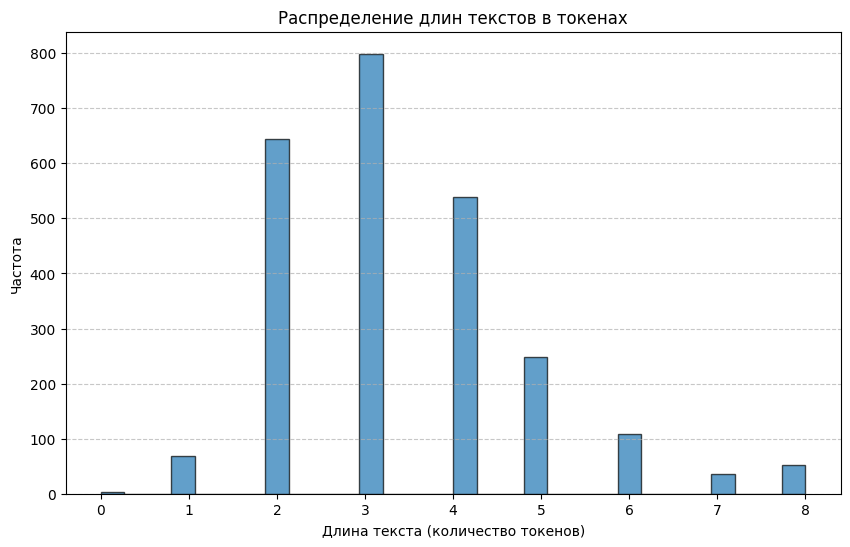

In [25]:
val_dataset.plot_token_length_distribution()

# Модель

In [26]:
from transformers import AutoConfig
from ml.model import BertForTokenClassificationCRF, TokenClassifierCRFOutput

num_labels = len(label2idx)

config = AutoConfig.from_pretrained(
    BASE_MODEL_NAME,
    num_labels=num_labels,
    id2label=idx2label,
    label2id=label2idx,
    cache_dir=DATA_CACHE,
)

model = BertForTokenClassificationCRF.from_pretrained(
    BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    config=config,
    ignore_mismatched_sizes=True,
)

model.gradient_checkpointing_enable()

Some weights of BertForTokenClassificationCRF were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight', 'crf.end_transitions', 'crf.start_transitions', 'crf.transitions']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Обучение

In [27]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=DATA_PATH_SAVE_MODELS / MODEL_CHECKPOINT_PATH,  # Папка для сохранения моделей
    num_train_epochs=10,  # Количество эпох

    eval_strategy="steps",  # Оценка модели после каждой эпохи
    eval_steps=200,  # Оценка модели каждый шаг
    logging_strategy="steps",  # Логирование каждые N шагов
    logging_steps=200,  # Как часто логировать
    disable_tqdm=False,  # Отключить tqdm (нужно для работы в Colab/Kaggle)
    report_to="tensorboard",  # Логируем в TensorBoard
    logging_dir=DATA_LOG,  # Папка для логов

    save_strategy="steps",  # Сохранение модели после каждой эпохи
    save_steps=200, # Если save_strategy="steps"
    save_total_limit=5,  # Храним все
    load_best_model_at_end=True,  # Загружать лучшую модель после обучения
    metric_for_best_model="eval_f1_macro",  # Выбираем лучшую модель по eval_f1_macro
    greater_is_better=True,  # Чем меньше eval_loss, тем лучше модель


    per_device_train_batch_size=BATCH_SIZE,  # Размер батча на одно устройство (GPU/CPU)
    per_device_eval_batch_size=BATCH_SIZE,  # Размер батча для валидации
)


In [28]:
from transformers import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)

steps_per_epoch = len(train_dataset.df) // training_args.per_device_train_batch_size
total_steps = steps_per_epoch * training_args.num_train_epochs

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.2 * total_steps),    # 20% шагов на разогрев
    num_training_steps=total_steps              # полный цикл косинусного затухания
)


In [29]:
def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return torch.argmax(logits, dim=-1)

In [30]:
import numpy as np
import torch
from collections import Counter

def compute_class_weights(train_dataset, num_labels):
    """
    train_dataset: твой NerDataSet (у которого есть поле .labels)
    num_labels: количество меток (len(label2idx))
    """
    all_labels = []

    # собираем все метки из датасета
    for labels in train_dataset.labels.tolist():
        for l in labels:
            if l != -100:  # игнорируем паддинги
                all_labels.append(l)

    counts = Counter(all_labels)
    total = sum(counts.values())

    # веса как обратные частоты
    class_weights = [total / counts.get(i, 1) for i in range(num_labels)]

    # нормализуем
    class_weights = np.array(class_weights, dtype=np.float32)
    class_weights = class_weights / class_weights.sum()

    return torch.tensor(class_weights, dtype=torch.float32)

class_weights_tensor = compute_class_weights(train_dataset, num_labels)


from torch.nn import CrossEntropyLoss

def weighted_crf_loss(emissions, labels, attention_mask, crf, class_weights_tensor, alpha=0.7):
    """
    Комбинированный лосс: CRF + Weighted CrossEntropy.
    alpha = баланс (0.0 → только CE, 1.0 → только CRF)
    """
    labels_for_crf = labels.clone().long()
    labels_for_crf[labels_for_crf == -100] = 0
    crf_loss = -crf(emissions, labels_for_crf, mask=attention_mask.bool(), reduction="mean")

    logits_flat = emissions.view(-1, emissions.size(-1))
    labels_flat = labels.view(-1)
    ce_loss_fn = CrossEntropyLoss(weight=class_weights_tensor.to(emissions.device), ignore_index=-100)
    ce_loss = ce_loss_fn(logits_flat, labels_flat)

    return alpha * crf_loss + (1 - alpha) * ce_loss

def weighted_loss(outputs: TokenClassifierCRFOutput, labels, num_items_in_batch=None):
    """
    compute_loss_func для Trainer в стиле (outputs, labels).
    Здесь labels уже Tensor, а не dict.
    """
    emissions = outputs.logits

    loss = weighted_crf_loss(
        emissions=emissions,
        labels=labels,
        attention_mask=outputs.attention_mask,
        crf=model.crf,
        class_weights_tensor=class_weights_tensor,
        alpha=0.7
    )

    return loss



In [31]:
from functools import partial

from ml.trainer import CustomBaseTrainer
from ml.metrics import compute_metrics

trainer = CustomBaseTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=partial(compute_metrics, idx2label=idx2label),
    processing_class=train_dataset.tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_loss_func=weighted_loss
)

In [ ]:
trainer.train()

In [ ]:
# trainer.plot_results()

In [32]:
test_results = trainer.predict(test_dataset)
print(test_results.metrics)

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'test_loss': 3.601110832077954e+24, 'test_model_preparation_time': 0.001, 'test_precision': 0.007990216061964941, 'test_recall': 0.02945596633603847, 'test_f1_micro': 0.012570548999486916, 'test_f1_macro': 0.010261302014702081, 'test_accuracy': 0.06760922004824443, 'test_runtime': 1.4577, 'test_samples_per_second': 1905.11, 'test_steps_per_second': 30.185}


In [33]:
trainer.save_model(DATA_PATH_SAVE_MODELS / MODEL_NAME_SAVE)

In [48]:
import json
from pathlib import Path

from ml.pipline import NERPipelineCRF

model_dir = DATA_PATH_SAVE_MODELS / "ner_x5_88"
label2idx_path = DATA_PATH_SAVE_MODELS / "label2idx.json"
idx2label_path = DATA_PATH_SAVE_MODELS / "idx2label.json"

with open(label2idx_path, "r", encoding="utf-8") as f:
    label2idx = json.load(f)

with open(idx2label_path, "r", encoding="utf-8") as f:
    idx2label = {int(k): v for k, v in json.load(f).items()}

pipeline = NERPipelineCRF(
    model_path=model_dir,
    label2idx=label2idx,
    idx2label=idx2label,
    max_length=16
)

text = "йогурт данисимо фантазия"
entities = pipeline.predict_text(text)
print(entities)


[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'йогурт'}, {'start_index': 7, 'end_index': 15, 'entity': 'B-BRAND', 'word': 'данисимо'}, {'start_index': 16, 'end_index': 24, 'entity': 'I-BRAND', 'word': 'фантазия'}]
